**CMSC673 - Audio Denoising Using LSTMs**

By: Matthew Hou

First, we need to install and import all the libraries that we are going to use for the project.  This includes installing the 'Noise Reduce' library, found at: https://github.com/timsainb/noisereduce for comparing the LSTM model against a this library. As well as importing Numpy for storing arrays of audio files, Librosa for reading in all the audio files, IPython for generating the output audio samples to hear back, Matplotlib for showing graphs of the results, and Keras for training our LSTM model.

*You can enable the GPU Accelerator by going to 'Runtime' -> 'Change runetime type' and set the Hardware accelerator to GPU.

In [ ]:
!pip install noisereduce
import numpy as np
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import noisereduce as nr


Next we need to download the audio files which can be found here: 
https://drive.google.com/drive/folders/1VGhR1_WrnPqrT9RMxndgEt8HbiNVEhNu?usp=sharing

The original audio files were taken from: https://www.voiptroubleshooter.com/open_speech/american.html 

Once downloaded, you can upload all the files in that directory into Google Colab by clicking "Files" (last icon) on the left hand side, and then upload these audio files into session storage.

Afterwards, we can read the audio files into an array and create the training data by ensuring sample lengths have a length of 1000 floats.  Note that we are not including all the samples into training since the last sample can be used as an audio example that the model has never seen before.

In [ ]:
# Load data
audios = []
for i in range(10, 20):
  f_name = 'OSR_us_000_00' + str(i) + '_8k.wav'
  print('Processing File: ', f_name)
  audio, samplerate = librosa.load(f_name)
  audios.append(audio)
training = np.array([])

# Exclude the last audio sample from being used in the training set
for i in range (len(audios)-1):
  curr_sample = audios[i]
  curr_len = int(len(curr_sample)-(len(curr_sample)%1000))
  training = np.concatenate((training,np.array(curr_sample[:int(curr_len)])))
print('Training Data Shape: ', training.shape)

Processing File:  OSR_us_000_0010_8k.wav
Processing File:  OSR_us_000_0011_8k.wav
Processing File:  OSR_us_000_0012_8k.wav
Processing File:  OSR_us_000_0013_8k.wav
Processing File:  OSR_us_000_0014_8k.wav
Processing File:  OSR_us_000_0015_8k.wav
Processing File:  OSR_us_000_0016_8k.wav
Processing File:  OSR_us_000_0017_8k.wav
Processing File:  OSR_us_000_0018_8k.wav
Processing File:  OSR_us_000_0019_8k.wav
Training Data Shape:  (6830000,)


Once we have the training data loaded in, we can create Gaussian noise that will be applied to the training data to mimic a noisy audio file.  This noisy data will serve to be our input to our LSTM model.  Next we can split the training and test set for training.

Audio without noise (First 4 seconds):


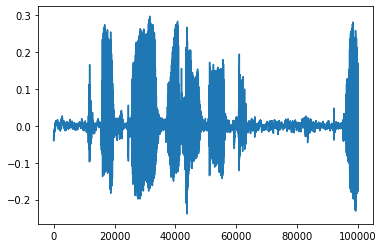

Audio with noise added (First 4 seconds):


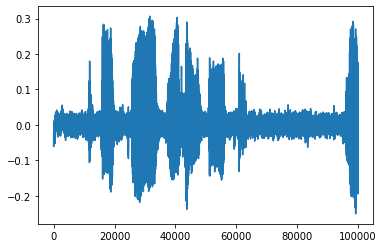

In [ ]:
# Add noise to training data
noise = np.random.normal(0, 0.01, (int(training.shape[0]),))
noisy_data = noise + training
print('Audio without noise (First 4 seconds):')
display(ipd.Audio(training[:100000], rate=samplerate))
plt.plot(training[:100000])
plt.show()
print('Audio with noise added (First 4 seconds):')
display(ipd.Audio(noisy_data[:100000], rate=samplerate))
plt.plot(noisy_data[:100000])
plt.show()

# Reshape inputs and outputs for training
X_shaped = np.reshape(noisy_data, (int(training.shape[0]/1000), 1, 1000))
Y_shaped = np.reshape(training, (int(training.shape[0]/1000), 1, 1000))

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X_shaped, Y_shaped, test_size=0.10, random_state=42)

Now that the data is all prepared, we can create our LSTM model.  Here we create an LSTM model that will process 1000 audio frequencies at a time using 'tanh' as our activiation function, 'mean_squared_error' as our loss function and 'adam' as our optimizer.

We can fit our training data with our model with 500 epochs and a batch size of 128.

When the model is done training, we can save our model as 'denoiser.k'

In [ ]:
# Create LSTM Model
model = Sequential()
model.add(LSTM((1000), input_shape=(1, 1000), return_sequences=True, activation='tanh'))
model.add(LSTM((1000), return_sequences=True, activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
history = model.fit(X_train, y_train, epochs=500, batch_size=128, verbose=2)
model.save('denoiser.k')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 1000)           8004000   
                                                                 
 lstm_1 (LSTM)               (None, 1, 1000)           8004000   
                                                                 
Total params: 16,008,000
Trainable params: 16,008,000
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
49/49 - 7s - loss: 0.0016 - 7s/epoch - 139ms/step
Epoch 2/500
49/49 - 1s - loss: 0.0013 - 1s/epoch - 22ms/step
Epoch 3/500
49/49 - 1s - loss: 9.1005e-04 - 1s/epoch - 23ms/step
Epoch 4/500
49/49 - 1s - loss: 7.1237e-04 - 1s/epoch - 23ms/step
Epoch 5/500
49/49 - 1s - loss: 5.5615e-04 - 1s/epoch - 23ms/step
Epoch 6/500
49/49 - 1s - loss: 4.3800e-04 - 1s/epoch - 23ms/step
Epoch 7/500
49/49 - 1s - loss: 3.5487e-04 - 1s/epoch - 23

INFO:tensorflow:Assets written to: denoiser.k/assets


INFO:tensorflow:Assets written to: denoiser.k/assets


Now the model is finished training, lets see how the training went.  Below is a graph of the MSE loss vs. training epoch over time from training the LSTM model.  As we can see from this graph, the model was able to learn successfully as the loss was reduced quite quickly and then becomes steady after some time.

In [ ]:
# compress model for downloading it for later use
!zip -r denoiser.zip denoiser.k/ 

  adding: denoiser.k/ (stored 0%)
  adding: denoiser.k/variables/ (stored 0%)
  adding: denoiser.k/variables/variables.index (deflated 66%)
  adding: denoiser.k/variables/variables.data-00000-of-00001 (deflated 46%)
  adding: denoiser.k/assets/ (stored 0%)
  adding: denoiser.k/saved_model.pb (deflated 91%)
  adding: denoiser.k/keras_metadata.pb (deflated 89%)


The final loss after training was:  1.6439618775621057e-05


Mean Squared Error from training


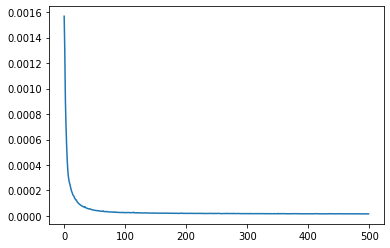

In [ ]:
loss = history.history['loss']
plt.plot(loss)
print('The final loss after training was: ', loss[len(loss)-1])
print('\n\nMean Squared Error from training')
plt.show()

Once the model is trained and saved, we can load the model(optional) and test how well it has done.  First test is to see how well it can denoise from one of the audio samples that it has already seen.  In this case we can use the first audio sample.

Audio with noise:


Audio output from LSTM Model


Plotted frequencies: Noisy Audio(Blue) vs. Model Output(Orange)


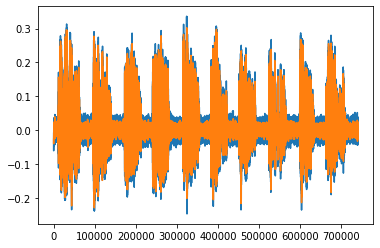

In [ ]:
# You can uncomment this line to load the model
# model = keras.models.load_model('denoiser.k')

# Prepare for testing
test1 = audios[0]
test1_shaped = test1[:int(len(test1)-(len(test1)%1000))]
noise = np.random.normal(0, 0.01, (int(test1_shaped.shape[0]),))
noisy_data = noise + test1_shaped

# Reshape inputs for testing
X_shaped = np.reshape(noisy_data, (int(test1_shaped.shape[0]/1000), 1, 1000))

# Predict and display results
predict = model.predict(X_shaped)
shaped_out = np.reshape(predict, (len(test1_shaped)))
print('Audio with noise:')
display(ipd.Audio(noisy_data[:100000], rate=samplerate))
print('Audio output from LSTM Model')
display(ipd.Audio(shaped_out[:100000], rate=samplerate))
print('Plotted frequencies: Noisy Audio(Blue) vs. Model Output(Orange)')
plt.plot(noisy_data)
plt.plot(shaped_out)
plt.show()

For further analysis, we can use the noise reduction library in python which comes from: https://github.com/timsainb/noisereduce and compare that with our LSTM Model.  we can see here that our LSTM Model has a lower loss than the loss produced by this library.

  0%|          | 0/2 [00:00<?, ?it/s]

MSE of Noise Reduce Library output vs. original:  0.001079193834243284
MSE of LSTM Model output vs. original:  2.4699779e-05


Plotted frequencies: Noisy Audio(Blue) vs. Noise Reduce Library Output(Orange) 


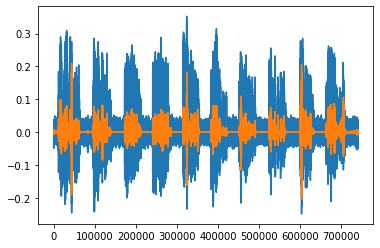


Plotted Error: Noise Reduce Library Output vs. Original


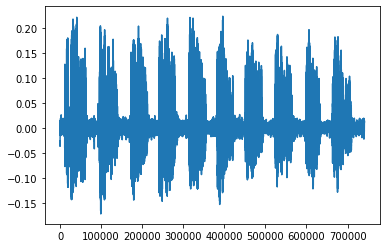


Plotted Error: LSTM Model Output vs. Original


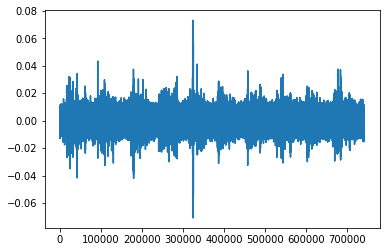

In [ ]:
# Using noise reduce library and compare MSE values
reduced_noise = nr.reduce_noise(y=noisy_data, sr=samplerate)
mse = ((reduced_noise - test1_shaped)**2).mean()
print('MSE of Noise Reduce Library output vs. original: ', mse)
mse = ((shaped_out - test1_shaped)**2).mean()
print('MSE of LSTM Model output vs. original: ', mse)
error_lstm = test1_shaped - shaped_out
error_library = test1_shaped - reduced_noise

# Plot noisy data with reduced noise data
print('\n\nPlotted frequencies: Noisy Audio(Blue) vs. Noise Reduce Library Output(Orange) ')
plt.plot(noisy_data)
plt.plot(reduced_noise)
plt.show()
print('\nPlotted Error: Noise Reduce Library Output vs. Original')
plt.plot(error_library)
plt.show()
print('\nPlotted Error: LSTM Model Output vs. Original')
plt.plot(error_lstm)
plt.show()

The second test we can do here is see how the model does when it encounters an audio sample that it has never seen before.  In this case we can use the last audio sample in 'audios' since that was not part of our training set.

Audio with noise:


Audio output from LSTM Model


Plotted frequencies: Noisy Audio(Blue) vs. Model Output(Orange)


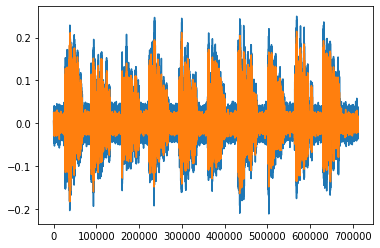

In [ ]:
# You can uncomment this line to load the model
# model = keras.models.load_model('denoiser.k')

# Prepare for testing
test2 = audios[len(audios)-1]
test2_shaped = test2[:int(len(test2)-(len(test2)%1000))]
noise = np.random.normal(0, 0.01, (int(test2_shaped.shape[0]),))
noisy_data = noise + test2_shaped


# Reshape inputs for testing
X_shaped = np.reshape(noisy_data, (int(test2_shaped.shape[0]/1000), 1, 1000))

# Predict and display results
predict = model.predict(model.predict(X_shaped))
shaped_out = np.reshape(predict, (len(test2_shaped)))
print('Audio with noise:')
display(ipd.Audio(noisy_data[:100000], rate=samplerate))
print('Audio output from LSTM Model')
display(ipd.Audio(shaped_out[:100000], rate=samplerate))
print('Plotted frequencies: Noisy Audio(Blue) vs. Model Output(Orange)')
plt.plot(noisy_data)
plt.plot(shaped_out)
plt.show()

Here we can test our model output to the Noise Reduce Library's output.  Once again our MSE is lower than the Noise Reduce Library.

  0%|          | 0/2 [00:00<?, ?it/s]

MSE of Noise Reduce Library output vs. original:  0.0005805362153251045
MSE of LSTM Model output vs. original:  4.6239085e-05


Plotted frequencies: Noisy Audio(Blue) vs. Noise Reduce Library Output(Orange) 


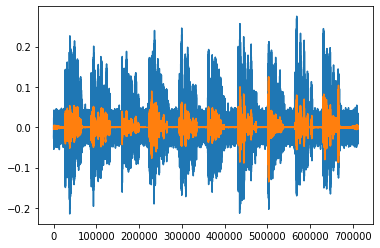

In [ ]:
# Using noise reduce library and compare MSE values
reduced_noise = nr.reduce_noise(y=noisy_data, sr=samplerate)
mse = ((reduced_noise - test1_shaped)**2).mean()
print('MSE of Noise Reduce Library output vs. original: ', mse)
mse = ((shaped_out - test1_shaped)**2).mean()
print('MSE of LSTM Model output vs. original: ', mse)

# Plot noisy data with reduced noise data
print('\n\nPlotted frequencies: Noisy Audio(Blue) vs. Noise Reduce Library Output(Orange) ')
plt.plot(noisy_data)
plt.plot(reduced_noise)
plt.show()

A last test we can do is to explore an audio file that is totally different in nature from the previous audio files.  In this test we will be using the first 3 seconds of Star War's Cantina Band music which has no speaker saying phrases and is soley instrumental.  Here we can see how it is still able to identify and remove some of the static background noise introduced into the audio clip.

Audio with noise:


Audio output from LSTM Model


MSE of Noise Reduce Library output vs. original:  0.0007719667499261366
MSE of LSTM Model output vs. original:  0.00024661297
Plotted frequencies: Noisy Audio(Blue) vs. Model Output(Orange)


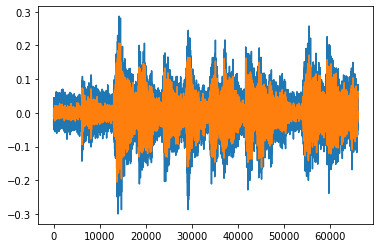



Plotted frequencies: Noisy Audio(Blue) vs. Noise Reduce Library Output(Orange) 


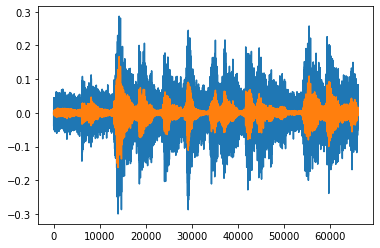


Plotted Error: Noise Reduce Library Output vs. Original


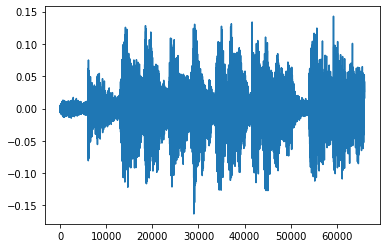


Plotted Error: LSTM Model Output vs. Original


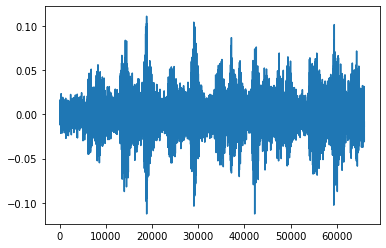

In [ ]:
# You can uncomment this line to load the model
# import zipfile
# with zipfile.ZipFile('denoiser.zip', 'r') as zip_ref:
#     zip_ref.extractall()
# model = keras.models.load_model('denoiser.k')

audio1, samplerate1 = librosa.load('CantinaBand3.wav')

# Prepare for testing

audio1 = audio1[:int(len(audio1)-(len(audio1)%1000))]
noise = np.random.normal(0, 0.02, (int(audio1.shape[0]),))
noisy_data = noise + audio1

# Reshape inputs for testing
X_shaped = np.reshape(noisy_data, (int(audio1.shape[0]/1000), 1, 1000))

# Predict and display results
predict = model.predict(X_shaped)
shaped_out = np.reshape(predict, (len(audio1)))
print('Audio with noise:')
display(ipd.Audio(noisy_data, rate=samplerate))
print('Audio output from LSTM Model')
display(ipd.Audio(shaped_out, rate=samplerate))
reduced_noise = nr.reduce_noise(y=noisy_data, sr=samplerate)
mse = ((reduced_noise - audio1)**2).mean()
print('MSE of Noise Reduce Library output vs. original: ', mse)
mse = ((shaped_out - audio1)**2).mean()
print('MSE of LSTM Model output vs. original: ', mse)
error_lstm = audio1 - shaped_out
error_library = audio1 - reduced_noise
print('Plotted frequencies: Noisy Audio(Blue) vs. Model Output(Orange)')
plt.plot(noisy_data)
plt.plot(shaped_out)
plt.show()
# Plot noisy data with reduced noise data
print('\n\nPlotted frequencies: Noisy Audio(Blue) vs. Noise Reduce Library Output(Orange) ')
plt.plot(noisy_data)
plt.plot(reduced_noise)
plt.show()
print('\nPlotted Error: Noise Reduce Library Output vs. Original')
plt.plot(error_library)
plt.show()
print('\nPlotted Error: LSTM Model Output vs. Original')
plt.plot(error_lstm)
plt.show()